In [480]:
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time  # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve  # ODE evolve tool
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import copy

### Build basis and Hamiltonian

In [481]:
Nsites = 6
Nbosons = 6
###### parameters
L_spin = Nsites - 1
L_modes = Nsites  # system size
cutoff = Nbosons + 1  #sites+2
h = 1  # field strength
t = 1

### Build projector onto gauge conserving basis

In [482]:
from qutip import *
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis


def flip(s):
    if s == '+':
        return '-'
    elif s == '-':
        return '+'


def isodd(n):
    return int(n) % 2 == True


def binom(n, k):
    return np.math.factorial(n) // np.math.factorial(k) // np.math.factorial(n - k)


def gaugeFixedBasis(Nsites, Nbosons):
    bosonStates = []
    gaugefixedStates = []
    # Let's first list out all possible boson occupations.
    # We can do this by looping through all numbers and putting it into base Nbosons
    for number in np.arange((Nbosons + 1) ** Nsites):
        bosonString = np.base_repr(number, base=Nbosons + 1)
        # print(bosonString)
        bosonString = '0' * (Nsites - len(bosonString)) + bosonString

        # check total boson number
        if sum([int(c) for c in bosonString]) == Nbosons:
            bosonStates.append(bosonString)

    # Now loop through each state and insert appropriate qubit state which fixes the gauge condition to +1
    for state in bosonStates:
        gaugefixedstate = ''
        for site in np.arange(len(state) - 1):
            thisn = state[site]
            gaugefixedstate += thisn
            if site == 0:  # For the first site
                thislink = '-' * (isodd(thisn)) + '+' * (not isodd(thisn))
            else:  # For all other sites
                if isodd(thisn):
                    thislink = flip(lastlink)
                else:
                    thislink = lastlink
            gaugefixedstate += thislink
            lastlink = thislink
        gaugefixedstate += state[-1]
        gaugefixedStates.append(gaugefixedstate)

    # print(gaugefixedStates)
    return gaugefixedStates


# Now that we have the gauge fixed basis vectors, we could proceed in a few different ways. The harder
# thing would be to build the Hamiltonian and all operators explicitly in this basis. While probably
# more efficient for very large systems, we could also just build projectors that take us from
# the full Hilbert space down to the gauge fixed Hilbert space. Let's do that here in Qutip:

def siteState(c, Nbosons):
    # print("site state ", basis(Nbosons + 1, int(c)))
    return basis(Nbosons + 1, np.abs(Nbosons-int(c)))


def linkState(c):
    if c == '+':
        # print("link state ", (basis(2, 0) + basis(2, 1)).unit())
        return (basis(2, 0) + basis(2, 1)).unit()
    elif c == '-':
        return (basis(2, 0) - basis(2, 1)).unit()


basisStatesList = gaugeFixedBasis(Nsites, Nbosons)
#print(basisStatesList)
# Build basis vectors in full Hilbert space
fullBasis = []
for state in basisStatesList:  # Loop through each basis state
    basisVector = []
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        # print("c ",c)
        if isodd(ind):
            basisVector.append(linkState(c))
    for ind in np.arange(len(state)):  # Loop through each site/link from left to right
        c = state[ind]
        if ind % 2 == 0:
            basisVector.append(siteState(c, Nbosons))

    # Now take tensor product to get the full basisVector
    fullBasis.append(tensor(basisVector))

# Now build projectors onto the gauge fixed Hilbert space
P_gaugefixed = 0
for i in np.arange(len(fullBasis)):
    P_gaugefixed += basis(len(fullBasis), i) * fullBasis[i].dag()

P_sparse = P_gaugefixed.data

In [483]:
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson = boson_basis_1d(L=L_modes, sps=cutoff)
# print(basis_boson)
basis = tensor_basis(basis_spin, basis_boson)
# print(basis.index("10","010"))

### Build Hamiltonian and calculate ground state

#### Hopping dominates: ground state is (1/2 |2+0> + 1/2 |0+2> + 1/sqrt(2) |1-1>)

In [530]:
hop = [[-10, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[0, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
# Relative phases for a two site system
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
# States with weight
for i in range(len(psi0)):
    print(np.abs(psi0[i]))
# Normalised
# print(abs(psi0.T.conj()@psi0)**2)
# Real?
# np.allclose(P_sparse.T.conj() @ psi0, P_sparse.T @ psi0)

[-7.53563878e-14] [2.57571742e-14] [-1.01113562e-13]
[0.00015561]
[0.00068683]
[0.00195687]
[0.00407165]
[0.00635391]
[0.0072412]
[0.0053269]
[0.00085647]
[0.00345093]
[0.00879408]
[0.01584639]
[0.02019087]
[0.01627083]
[0.00304285]
[0.01096604]
[0.0242011]
[0.0356065]
[0.03208035]
[0.00789493]
[0.02464047]
[0.04440058]
[0.04619211]
[0.01536308]
[0.03915011]
[0.0498836]
[0.0218327]
[0.03934116]
[0.02002769]
[0.00085647]
[0.00345093]
[0.00879408]
[0.01584639]
[0.02019087]
[0.01627083]
[0.00430323]
[0.01550832]
[0.03422553]
[0.0503552]
[0.04536847]
[0.01367443]
[0.04267854]
[0.07690407]
[0.08000709]
[0.03072616]
[0.07830023]
[0.09976721]
[0.04881939]
[0.08796951]
[0.04905762]
[0.00304285]
[0.01096604]
[0.0242011]
[0.0356065]
[0.03208035]
[0.01367443]
[0.04267854]
[0.07690407]
[0.08000709]
[0.0376317]
[0.0958978]
[0.12218938]
[0.06904105]
[0.12440767]
[0.07756692]
[0.00789493]
[0.02464047]
[0.04440058]
[0.04619211]
[0.03072616]
[0.07830023]
[0.09976721]
[0.06904105]
[0.12440767]
[0.089566

In [531]:
psi0_notgaugefixed = P_sparse.T @ psi0
for i in range(Nbosons):
    obs_args={"basis":basis,"check_herm":False,"check_symm":False}
    n=hamiltonian([["|n", [[1.0,i]] ]],[],dtype=np.float64,**obs_args)
    Obs_t = obs_vs_time(psi0_notgaugefixed,t,{"n":n})
    O_n = Obs_t["n"]
    print(i, " ", np.real(O_n))

/tmp/ipykernel_24753/2477622136.py:4: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,i]] ]],[],dtype=np.float64,**obs_args)


0   [0.32272303]
1   [1.04787509]
2   [1.62940189]
3   [1.62940189]
4   [1.04787509]
5   [0.32272303]


In [11]:
##### define initial state #####
psispin=(1/np.sqrt(2))*np.array([1,1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("010")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
psiboson[iboson] = 1.0
psi=np.kron(psispin,psiboson)

##### Check state we just made (not in use)

In [14]:
field = [[1.0,2]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static=[["|n",field]] #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_check = hamiltonian(static,[],basis=basis,**no_checks)
print(np.dot(psi.conj().T,H_check.dot(psi)))

ValueError: values in indx falls outside of system

In [532]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(O_n)
    n = [[1.0,i,i]]
    static=[["|nn",n]]
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n2 = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(O_n2)
    print(i, " ", 1-(2*np.abs(O_n))+(np.abs(O_n2)))

[[0.32272303+0.j]]
[[0.40951482+1.38777878e-17j]]
0   [[0.76406877]]
[[1.04787509+0.j]]
[[1.96291025+0.j]]
1   [[0.86716008]]
[[1.62940189+0.j]]
[[3.84186064+0.j]]
2   [[1.58305687]]
[[1.62940189+0.j]]
[[3.84186064+0.j]]
3   [[1.58305687]]
[[1.04787509+0.j]]
[[1.96291025+0.j]]
4   [[0.86716008]]
[[0.32272303+0.j]]
[[0.40951482+0.j]]
5   [[0.76406877]]


[[ 0.64544605  2.09575017  3.25880377  3.25880377  2.09575017  0.64544605]
 [ 1.1630536   2.61335772  3.25880377  2.61335772  1.1630536  -1.        ]
 [ 1.45030412  2.61335772  2.61335772  1.45030412 -1.         -1.        ]
 [ 1.45030412  2.09575017  1.45030412 -1.         -1.         -1.        ]
 [ 1.1630536   1.1630536  -1.         -1.         -1.         -1.        ]
 [ 0.64544605 -1.         -1.         -1.         -1.         -1.        ]]


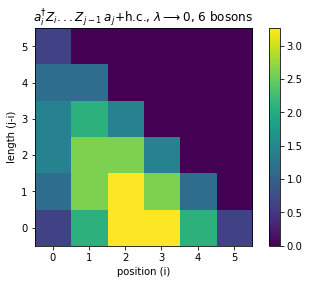

In [533]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

# from matplotlib import cm
print(resRe.T)
plt.imshow(resRe.T)#,cmap=cm.Reds)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

In [ ]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()

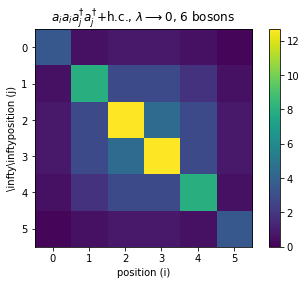

In [540]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("\infty\inftyposition (j)")
plt.clim(0,resRe.max())
# plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()

#### Positive field dominates so |-> lowers the energy the most: ground state is |1-1>

In [510]:
hop = [[-0.1, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[100, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))

[1.71610748] [-0.76375698] [2.47986447]
[1.51701912e-17] [2.41931748e-16] [8.9506062e-18]


In [494]:
E, psi0 = eigsh(Hgaugefixed, k=4, which='SA')
print(E)
print(psi0)

[-500. -500. -500. -500.]
[[ 4.42938027e-18+7.77799220e-18j  3.21417594e-17-3.37975645e-18j
  -8.27231564e-19-7.23548880e-19j -3.63254166e-19-2.83367063e-19j]
 [ 1.06647832e-18+2.41655822e-19j  2.07449416e-18-5.65509826e-18j
  -5.63485995e-18-6.36090357e-18j  6.80876497e-20+1.03734399e-18j]
 [ 3.88075224e-18-2.06027546e-19j  3.17357790e-17+1.24927333e-17j
  -2.51207409e-19-7.62416643e-19j -1.75177405e-19-1.69498036e-19j]
 ...
 [-2.64533780e-19+1.05633088e-19j  2.08695157e-20+8.45565202e-21j
  -1.34517385e-21+2.28273997e-20j -2.51618038e-21+1.42076429e-21j]
 [ 2.83743653e-18-5.30704444e-19j -6.36186636e-18+1.45539009e-17j
  -8.90427786e-18-5.84862478e-18j  1.48002051e-18+4.09445855e-18j]
 [ 2.17462593e-18-4.57286410e-19j  6.24721266e-19+2.62408328e-18j
   3.39590223e-19-1.30341711e-19j  9.49929336e-20-3.95278783e-20j]]
[-500.00152402 -500.00152924 -500.00126284 -500.00119305]
[[ 8.95563827e-19+6.69128406e-19j  1.04232975e-17-1.19296561e-17j
   1.94906204e-17-1.34012259e-17j  7.36336409e

In [511]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(i, " ", np.real(O_n))

0   [[1.39971267]]
1   [[1.2672707]]
2   [[0.33301538]]
3   [[0.33301574]]
4   [[1.26727232]]
5   [[1.39971319]]


In [512]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(i, " ", np.real(O_n))

0   [[1.39971267]]
1   [[1.2672707]]
2   [[0.33301538]]
3   [[0.33301574]]
4   [[1.26727232]]
5   [[1.39971319]]


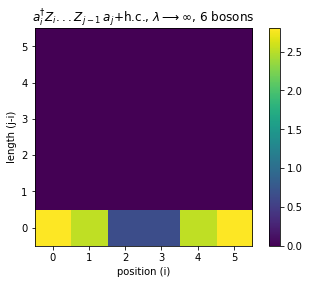

In [513]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe.T)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

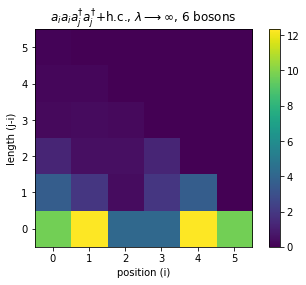

In [514]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

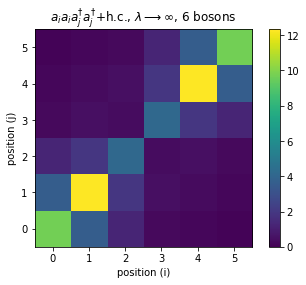

In [515]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("position (j)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

In [19]:
###### parameters
h = 1 # field strength
t_min = -5 # hopping strength
t_max = 5
numberofvaluesof_t = 50
tvals=np.linspace(t_min,t_max,numberofvaluesof_t)
###### create the basis
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson=boson_basis_1d(L=L_modes, sps=cutoff)
basis = tensor_basis(basis_spin,basis_boson)

# Different system sizes and number of bosons - choose number of bosons to be equal to the system size

gj=1
deltas=np.zeros((2,len(tvals)))
energy0=np.zeros((2,len(tvals)))
energy1=np.zeros((2,len(tvals)))
energy2=np.zeros((2,len(tvals)))
energy3=np.zeros((2,len(tvals)))
for i in range(len(tvals)):
    t=tvals[i]
    ##### create model
    hop=[[-h,i,i,i+1] for i in range(L_modes-1)]
    density = [[0,i,i] for i in range(L_modes)]
    field = [[t,i] for i in range(L_spin)]
    static=[["z|+-",hop],["z|-+",hop],["x|",field]]#,["|nn",density]]
    ###### setting up operators
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,[],basis=basis,**no_checks)
    H_sparse = H.tocsr()

    Hgaugefixed=P_sparse@H_sparse@P_sparse.T.conj()
    print("done ")
    E,V = eigsh(Hgaugefixed,k=2,which='SA')
    delta=np.abs(E[1]-E[0])
    if t==0:
        print("E[0] ",E[0]," E[1] ",E[1]," delta ",delta)
    deltas[0][i]=t
    deltas[1][i]=np.abs(delta)

    energy0[0][i]=t
    energy0[1][i]=E[0]

    energy1[0][i]=t
    energy1[1][i]=E[1]

    # energy2[0][i]=t
    # energy2[1][i]=E[1]
    #
    # energy3[0][i]=t
    # energy3[1][i]=E[2]

set.append(deltas)

done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 


In [20]:
lab.append(str(Nsites)+" sites, "+str(Nbosons)+" bosons")

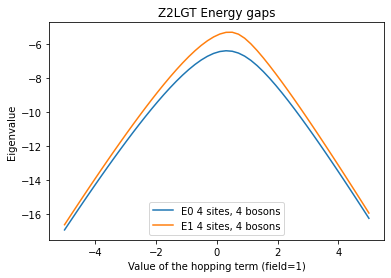

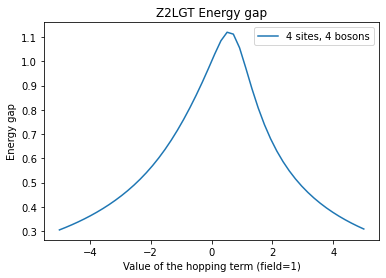

In [21]:
plt.title("Z2LGT Energy gaps")
for i in range(len(set)):
    plt.plot(energy0[0],energy0[1],label="E0 "+lab[i])
for i in range(len(set)):
    plt.plot(energy1[0],energy1[1],label="E1 "+lab[i])
# for i in range(len(set)):
#     plt.plot(energy2[0],energy2[1],label="E3 "+lab[i])
# for i in range(len(set)):
#     plt.plot(energy3[0],energy3[1],label="E4 "+lab[i])
plt.xlabel("Value of the hopping term (field=1)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

plt.title("Z2LGT Energy gap")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],label=lab[i])
# plt.yscale("log")
plt.xlabel("Value of the hopping term (field=1)")
plt.ylabel("Energy gap")
plt.legend()
plt.show()

### Create |0+2> by hand and check where it is in the basis

In [10]:
##### define initial state #####
psispin = (1 / np.sqrt(2)) * np.array([1, 1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("02")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns, dtype=np.float64)
psiboson[iboson] = 1.0
psi = np.kron(psispin, psiboson)
print(psi)

[0.         0.         0.         0.         0.         0.
 0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.70710678 0.         0.        ]


In [11]:
# Check the state which was made
statetest = [[1.0,
              1]]  #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static = [["|n", statetest]]  #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H_check = hamiltonian(static, [], basis=basis, **no_checks)
print(np.dot(psi.conj().T, H_check.dot(psi)))

(1.9999999999999996+0j)
